In [1]:
!unzip -u "/content/cartoon.zip" -d "/content/cartoon"

Archive:  /content/cartoon.zip
  inflating: /content/cartoon/cartoon/cs11500768489142118159.png  
  inflating: /content/cartoon/cartoon/cs11496839623386988994.png  
  inflating: /content/cartoon/cartoon/cs11501710450116498461.png  
  inflating: /content/cartoon/cartoon/cs1149648339250881314.png  
  inflating: /content/cartoon/cartoon/cs11500463050250299821.png  
  inflating: /content/cartoon/cartoon/cs11501981190804367864.png  
  inflating: /content/cartoon/cartoon/cs115015743350173470.png  
  inflating: /content/cartoon/cartoon/cs11497077681490484507.png  
  inflating: /content/cartoon/cartoon/cs11496285006672394132.png  
  inflating: /content/cartoon/cartoon/cs11501385337001567920.png  
  inflating: /content/cartoon/cartoon/cs11499959365834285203.png  
  inflating: /content/cartoon/cartoon/cs1149858768437496562.png  
  inflating: /content/cartoon/cartoon/cs11499323325775509736.png  
  inflating: /content/cartoon/cartoon/cs11501642145622483224.png  
  inflating: /content/cartoon/carto

Found 200 files.
Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 709ms/step - loss: 98.7761
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.3789
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.4465
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3769
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3481
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3301
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.3020
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.2967
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.2892 
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2796
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.2692
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2728
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.2522
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2497
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2520
Epoch 16/60

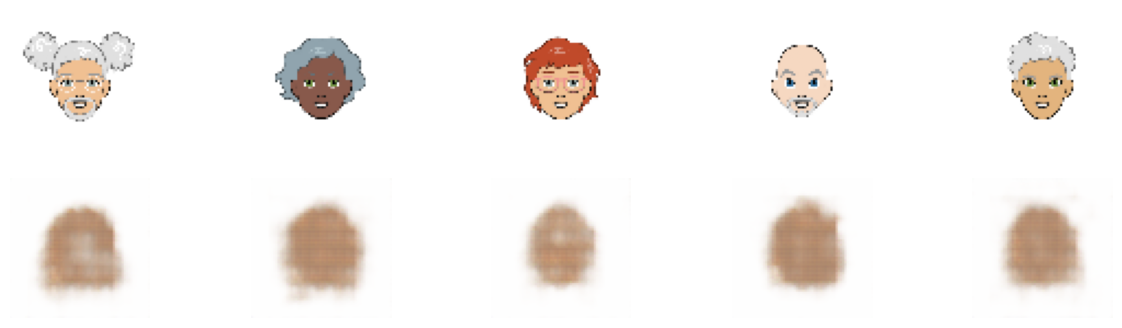

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Load dataset
def load_cartoon_images(image_size=(64, 64), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/cartoon",
        image_size=image_size,
        batch_size=batch_size,
        label_mode=None,
        shuffle=True
    )
    return dataset.map(lambda x: x / 255.0)

# Sampling function
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# Build Decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

# Custom VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# Instantiate everything
latent_dim = 512
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Train
dataset = load_cartoon_images()
vae.fit(dataset, epochs=60)

# Show results
def show_reconstruction(model, dataset):
    for batch in dataset.take(1):
        reconstruction = model(batch)
        plt.figure(figsize=(15, 4))
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(batch[i])
            plt.axis('off')
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstruction[i])
            plt.axis('off')
        plt.show()

show_reconstruction(vae, dataset)
